## Given a hex maze configuration, we want a set of next possible barrier sets!

Each new configuration needs to be different by the movement of a single barrier.

We currently have 2 additional criteria for valid mazes created by a barrier change:
1. At least one path must be longer and one must be shorter.
2. The optimal path order must have changed (the pair of reward ports that used to be the closest together or furthest apart is now different).

For some of our functions, we can choose if new mazes must satisfy both ("ALL") or either ("ANY") of these criteria.

In [1]:
import pandas as pd
import pickle
import sys
sys.path.append("..")  # Use sys to add the parent directory (where hex_maze_utils lives) to the path

# Load the database and visualize it
df = pd.read_pickle('../maze_configuration_database.pkl')
display(df)

,barriers,len12,len13,len23,reward_path_lengths,path_length_difference,optimal_paths_12,optimal_paths_13,optimal_paths_23,optimal_paths_all,choice_points,num_choice_points,cycles,num_cycles,isomorphic_mazes
0,"(37, 39, 7, 41, 14, 46, 20, 23, 30)",15,17,21,"[15, 17, 21]",6,"[[1, 4, 6, 8, 10, 13, 17, 21, 26, 22, 27, 32, ...","[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 1...","[[1, 4, 6, 8, 10, 13, 17, 21, 26, 22, 27, 32, ...",{13},1,[],0,"{(37, 8, 9, 40, 20, 21, 22, 27, 28), (34, 8, 4..."
1,"(34, 36, 37, 39, 10, 45, 14, 15, 20)",17,21,19,"[17, 21, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 25, 30, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 25, 30, 35, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{21},1,[],0,"{(34, 37, 8, 40, 10, 15, 18, 20, 26), (34, 35,..."
2,"(34, 7, 41, 11, 46, 17, 20, 28, 31)",23,19,17,"[23, 19, 17]",6,"[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...","[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...","[[2, 49, 38, 32, 27, 22, 26, 21, 25, 30, 35, 4...","[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...",{35},1,"[[38, 49, 47, 42, 37, 32]]",1,"{(35, 7, 10, 44, 20, 22, 27, 28, 31), (32, 37,..."
3,"(34, 10, 42, 12, 45, 18, 23, 25, 31)",15,19,21,"[15, 19, 21]",6,"[[1, 4, 6, 8, 11, 14, 17, 21, 26, 22, 27, 32, ...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 6, 8, 11, 14, 17, 21, 26, 22, 27, 32, ...",{17},1,[],0,"{(34, 37, 8, 40, 13, 46, 15, 18, 25), (34, 37,..."
4,"(39, 9, 10, 46, 21, 22, 23, 26, 30)",23,17,17,"[23, 17, 17]",6,"[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[2, 49, 38, 32, 37, 31, 36, 41, 45, 40, 35, 2...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...",{29},1,"[[32, 38, 49, 47, 42, 37], [12, 15, 19, 24, 20...",2,"{(34, 36, 8, 41, 9, 21, 23, 27, 30), (10, 11, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55891,"(34, 36, 7, 10, 42, 46, 19, 22, 25)",15,19,21,"[15, 19, 21]",6,"[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 37, 32, ...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[2, 49, 38, 32, 37, 31, 26, 21, 17, 13, 16, 2...","[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 37, 32, ...",{17},1,[],0,"{(34, 37, 7, 40, 9, 42, 14, 16, 25), (35, 37, ..."
55892,"(37, 7, 9, 13, 45, 16, 22, 25, 29)",17,19,15,"[17, 19, 15]",4,"[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 36, 41, ...","[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 36, 30, ...","[[2, 49, 47, 42, 46, 41, 36, 30, 35, 40, 44, 3...","[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 36, 41, ...",{36},1,"[[34, 28, 33, 48, 43, 39]]",1,"{(32, 34, 40, 13, 15, 25, 26, 27, 31), (36, 10..."
55893,"(7, 39, 46, 17, 19, 22, 23, 24, 30)",17,23,17,"[17, 23, 17]",6,"[[1, 4, 6, 8, 10, 13, 16, 20, 25, 21, 26, 31, ...","[[1, 4, 6, 8, 10, 13, 16, 20, 25, 21, 26, 31, ...","[[2, 49, 38, 32, 37, 31, 36, 41, 45, 40, 35, 2...","[[1, 4, 6, 8, 10, 13, 16, 20, 25, 21, 26, 31, ...",{31},1,"[[32, 38, 49, 47, 42, 37]]",1,"{(32, 36, 7, 40, 11, 14, 17, 20, 23), (32, 36,..."
55894,"(34, 10, 11, 42, 45, 15, 22, 25, 30)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 37, 31, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...",{16},1,"[[19, 23, 28, 33, 48, 43, 39, 44, 40, 35, 29, ...",1,"{(34, 37, 8, 12, 45, 18, 21, 23, 25), (37, 40,..."


### Getting a new barrier set given an initial barrier set

Given a starting barrier set, let's find all potential next barrier sets that differ by the movement of a single barrier. 

We can also find which one of these is the best (i.e. the optimal paths that the rat can travel between reward ports are maximally different - in number of hexes - from the original barrier set)

Original barrier set: {34, 10, 42, 12, 45, 18, 23, 25, 31}

Potential next barrier sets: [frozenset({34, 10, 12, 45, 18, 22, 23, 25, 31}), frozenset({34, 10, 12, 45, 18, 23, 25, 26, 31}), frozenset({34, 10, 12, 45, 18, 23, 25, 27, 31}), frozenset({34, 10, 12, 45, 18, 21, 23, 25, 31}), frozenset({32, 34, 10, 12, 45, 18, 23, 25, 31})]

Best next barrier set: frozenset({34, 10, 12, 45, 18, 22, 23, 25, 31})
Original barriers:


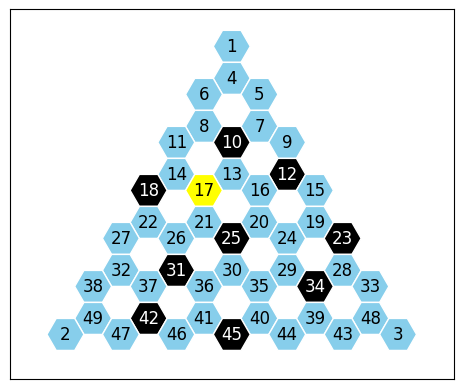

Best next barriers:


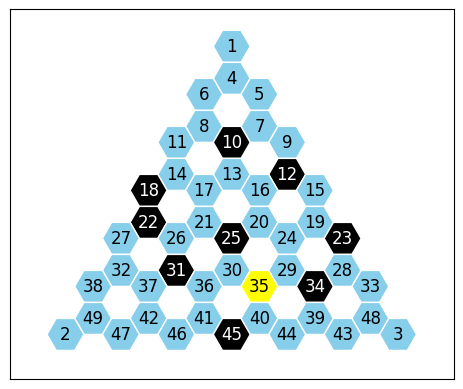

In [2]:
from hex_maze_utils import get_next_barrier_sets, get_best_next_barrier_set, plot_hex_maze

# Here is an example of our original barrier set
original_barriers = {34, 10, 42, 12, 45, 18, 23, 25, 31}
print(f"Original barrier set: {original_barriers}\n")

# Given this set of barriers, we can find all possible sets of next barriers
next_barrier_sets = get_next_barrier_sets(df, original_barriers, criteria_type='ALL')
print(f"Potential next barrier sets: {next_barrier_sets}\n")

# We can also find the "best" one (best = optimal paths maximally different from the original barrier set)
best_next_barrier_set = get_best_next_barrier_set(df, original_barriers)
print(f"Best next barrier set: {best_next_barrier_set}")

# Let's plot the hex mazes of the original barrier set and the best next set to see what this looks like
print("Original barriers:")
plot_hex_maze(original_barriers)
print("Best next barriers:")
plot_hex_maze(best_next_barrier_set)

### Getting a barrier sequence given an initial barrier set

Longer sequences are a bit harder - we want to make sure that each barrier set is different enough from the previous barrier set, AND also different enough from all other previous mazes in the sequence.

To do this, we can set a threshold "min_hex_diff" : this is the combined minimum number of hexes that need to be different on optimal paths to reward ports between ALL mazes in a sequence

Note that this function doesn't necessarily give us the BEST possible barrier sequence, it just gives us a valid sequence. It does ensure that the sequence returned is the longest possible sequence that fits our criteria, but if there were ties for the longest possible sequence, it just returns the first one.

Potential barrier sequence: [{34, 10, 42, 12, 45, 18, 23, 25, 31}, frozenset({34, 37, 10, 42, 12, 45, 18, 23, 25}), frozenset({34, 37, 10, 12, 45, 18, 23, 25, 26}), frozenset({34, 37, 10, 12, 45, 18, 22, 23, 25}), frozenset({34, 35, 37, 10, 12, 45, 18, 22, 25})]
Barrier set 0: {34, 10, 42, 12, 45, 18, 23, 25, 31}


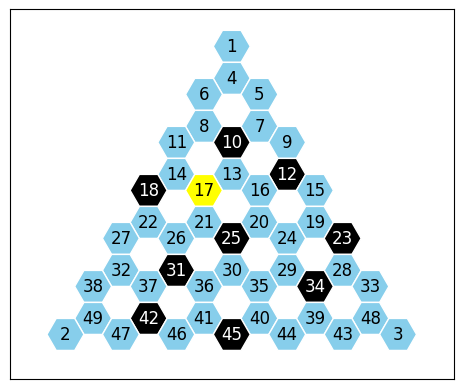

Barrier change: 31 -> 37
Barrier set 1: frozenset({34, 37, 10, 42, 12, 45, 18, 23, 25})


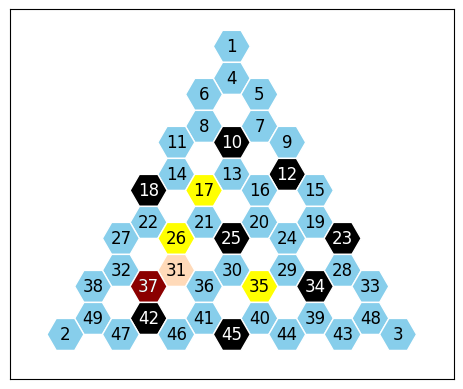

Barrier change: 42 -> 26
Barrier set 2: frozenset({34, 37, 10, 12, 45, 18, 23, 25, 26})


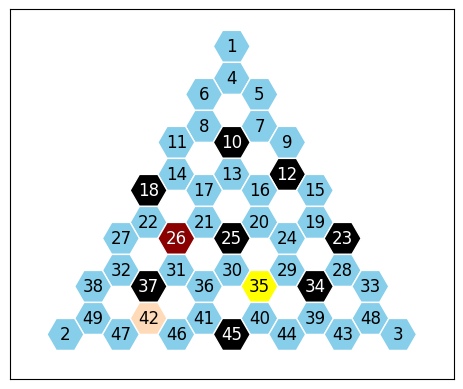

Barrier change: 26 -> 22
Barrier set 3: frozenset({34, 37, 10, 12, 45, 18, 22, 23, 25})


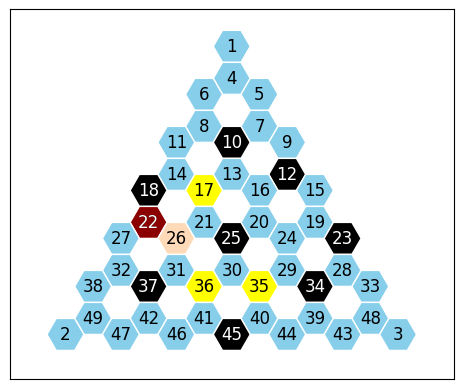

Barrier change: 23 -> 35
Barrier set 4: frozenset({34, 35, 37, 10, 12, 45, 18, 22, 25})


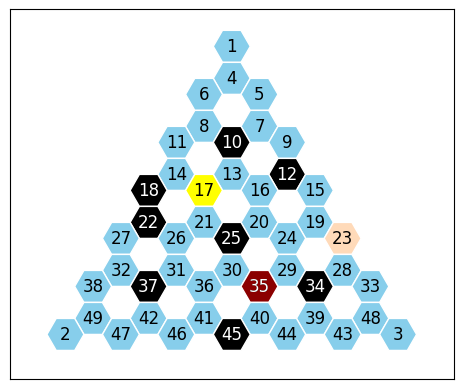

In [3]:
from hex_maze_utils import get_barrier_sequence, plot_barrier_change_sequence

original_barriers = {34, 10, 42, 12, 45, 18, 23, 25, 31}

# Given a set of original barriers, get a potential barrier sequence
barrier_sequence = get_barrier_sequence(df, original_barriers, min_hex_diff=8, max_sequence_length=5)

print(f"Potential barrier sequence: {barrier_sequence}")

# Plot all of the mazes in the sequence
plot_barrier_change_sequence(barrier_sequence)

### Getting all possible barrier sequence given an initial barrier set

What if we don't like the given sequence? We can get all possible barrier sequences to investigate them further. 

Note that this can be pretty computationally expensive to run, expecially if we relax the "min_hex_diff" criteria and end up with a lot of sequences

Our starting maze is {34, 10, 42, 12, 45, 18, 23, 25, 31}
Original path lengths: [15, 19, 21]


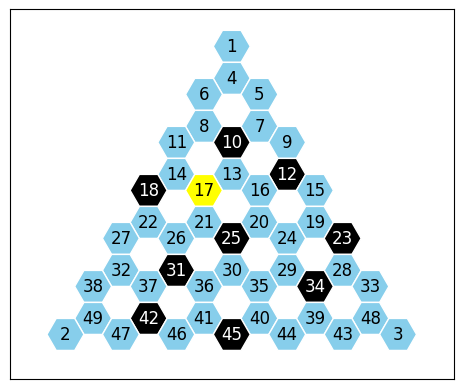

KeyboardInterrupt: 

In [4]:
from hex_maze_utils import find_all_valid_barrier_sequences, df_lookup, plot_hex_maze

original_barriers = {34, 10, 42, 12, 45, 18, 23, 25, 31}

print(f"Our starting maze is {original_barriers}")
print(f"Original path lengths: {df_lookup(df, original_barriers, 'reward_path_lengths')}")
plot_hex_maze(original_barriers)

# Given a set of original barriers, get all potential barrier sequences
all_barrier_sequences = find_all_valid_barrier_sequences(df, original_barriers, min_hex_diff=8, max_sequence_length=5)

for sequence in all_barrier_sequences:
    print(f"Potential barrier sequence: {sequence}")

Yikes. That's a lot of potential sequences! That's why we choose to stop at a "good enough" barrier sequence instead of checking all of them!

### Set up a database of potential barrier sequences
Now let's store some of these potential sequences in a database! Currently we are generating sequences where the optimal paths between reward ports for ALL mazes in the sequence must differ from the optimal paths for all other mazes in the sequence by at least 9 hexes (combined across all optimal paths).

In [ ]:
from tqdm import tqdm
import pickle
from hex_maze_utils import get_barrier_sequence, get_barrier_sequence_attributes

# Load our saved set of all valid maze configurations
with open('example_data/all_valid_maze_configs.pkl', 'rb') as file:
    all_valid_mazes = pickle.load(file)
    
# Convert it to a list so we can iterate
all_mazes = list(all_valid_mazes)
print(f"We have {len(all_mazes)} maze configurations!")

barrier_sequence_dicts = []

# Create a database of barrier sequences starting from mazes 1000-2000 in our list of mazes
for maze in tqdm(all_mazes[1000:2000]):
    # Calculate a potential barrier sequence for each maze
    barrier_sequence = get_barrier_sequence(df, maze, min_hex_diff=9, max_sequence_length=6)
    
    # Get attributes for this sequence
    sequence_dict = get_barrier_sequence_attributes(barrier_sequence)

    # Add it to our dictionary
    barrier_sequence_dicts.append(sequence_dict)

# Create DataFrame
barrier_sequence_database = pd.DataFrame(barrier_sequence_dicts)

print("Here is our database!")
display(barrier_sequence_database)

In [3]:
save = False # be warned that saving will overwrite already saved files of the same name

if save:
    # Save the database as a CSV for readability without loading in a notebook
    barrier_sequence_database.to_csv('Barrier_Sequence_Databases/barrier_sequences_second1000.csv', index=False)
    
    # And also using pickle - this is better for loading in notebooks
    barrier_sequence_database.to_pickle('Barrier_Sequence_Databases/barrier_sequences_second1000.pkl')

### Loading the database for use in your notebooks! 

IMPORTANT: Make sure to load the pickle (.pkl) version instead of the csv (.csv) version - the csv version loads variables as strings and messes things up. 

(We save both versions because the csv version is nice if you want to open the database in excel or something)

In [8]:
# Loads the database as "df"
df = pd.read_pickle('../Barrier_Sequence_Databases/barrier_sequences_first1000.pkl')
display(df)

,barrier_sequence,sequence_length,reward_path_lengths,choice_points
0,"[(37, 7, 39, 41, 14, 46, 20, 23, 30), (37, 39,...",5,"[[15, 17, 21], [15, 21, 19], [15, 17, 19], [23...","[{13}, {26}, {26, 13, 29}, {29}, {13}]"
1,"[(34, 36, 37, 39, 10, 45, 14, 15, 20), (34, 37...",6,"[[17, 21, 19], [19, 21, 17], [19, 15, 17], [17...","[{21}, {30}, {24}, {16, 24, 26}, {24}, {35}]"
2,"[(34, 7, 41, 11, 46, 17, 20, 28, 31)]",1,"[[23, 19, 17]]",[{35}]
3,"[(34, 10, 42, 12, 45, 18, 23, 25, 31), (34, 37...",6,"[[15, 19, 21], [15, 19, 17], [21, 19, 15], [21...","[{17}, {17, 26, 35}, {35}, {24}, {24, 17, 26},..."
4,"[(39, 9, 10, 46, 21, 22, 23, 26, 30)]",1,"[[23, 17, 17]]",[{29}]
...,...,...,...,...
995,"[(32, 34, 45, 13, 14, 15, 18, 19, 25), (32, 34...",2,"[[19, 17, 15], [19, 15, 17]]","[{35}, {24}]"
996,"[(37, 7, 40, 13, 46, 45, 18, 25, 28), (37, 7, ...",2,"[[15, 19, 17], [17, 19, 15]]","[{26}, {36}]"
997,"[(36, 10, 11, 46, 15, 21, 25, 27, 29)]",1,"[[19, 15, 21]]",[{16}]
998,"[(32, 8, 9, 41, 15, 20, 21, 27, 29), (32, 8, 9...",2,"[[17, 21, 15], [17, 15, 21]]","[{31}, {13}]"
